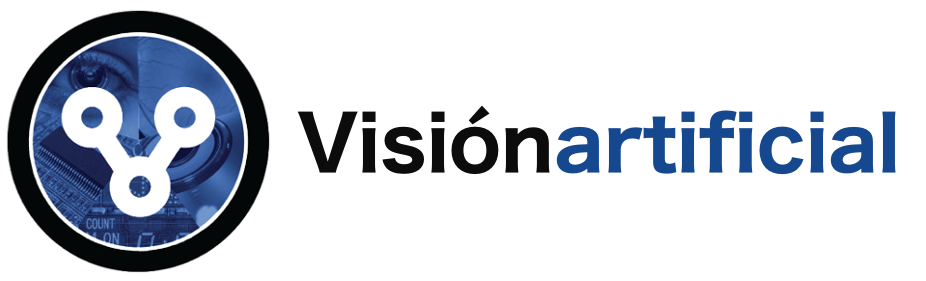

# OpenCV 

### para a materia de Visión Artificial do Grao de Robótica. EPSE de Lugo.

<hr style = "border: none; height: 4px; background-color: # D3D3D3" />

# <font style="color:rgb(50,120,229)">Estabilización dun vídeo empregando o método Point Feature Matching de OpenCV</font>

Neste módulo, aprenderemos a implementar un estabilizador de vídeo sinxelo usando unha técnica chamada Point Feature Matching na biblioteca OpenCV. Discutiremos o algoritmo e compartiremos o código (en python) para deseñar un estabilizador usando este método en OpenCV.

## <font style="color:rgb(50,120,229)">Estabilización dun vídeo</font>

**A estabilización de vídeo** refírese a unha familia de métodos utilizados para reducir o efecto do movemento da cámara no vídeo final. O movemento da cámara sería unha translación (é dicir, movemento na dirección x, y, z) ou rotación (yaw, pitch, roll).

Mira este [vídeo](https://www.youtube.com/watch?v=NMGNak2u3Rc) e observa o movemento da cámara de baixa frecuencia.

## <font style="color:rgb(50,120,229)">Applicación da estabilización de vídeos</font>

A necesidade de estabilización de vídeo abarca moitos dominios.

É moi importante na **videografía** de consumo e profesional. Polo tanto, existen moitas solucións mecánicas, ópticas e algorítmicas diferentes. Incluso na **fotografía** de imaxes fixas, a estabilización pode axudar a facer fotos coa man con tempos de exposición longos.

En aplicacións de **diagnóstico médico** como a endoscopia e a colonoscopia, os vídeos deben estabilizarse para determinar a localización exacta e o ancho do problema.

Do mesmo xeito, nas **aplicacións militares**, os vídeos capturados por vehículos aéreos nun voo de recoñecemento deben estabilizarse para a localización, navegación, seguimento de obxectivos, etc. O mesmo para ás **aplicacións robóticas**.

## <font style="color:rgb(50,120,229)">Diferentes enfoques para a estabilización de vídeo</font>

Os enfoques da estabilización de vídeo inclúen métodos mecánicos, ópticos e dixitais. Estes son discutidos brevemente a continuación:

- **Estabilización de vídeo mecánica**: os sistemas de estabilización de imaxe mecánica utilizan o movemento detectado por sensores especiais como xiroscopios e acelerómetros para mover o sensor de imaxe e compensar o movemento da cámara.

- **Estabilización óptica de vídeo**: neste método, en lugar de mover toda a cámara, a estabilización conséguese movendo partes da lente. Este método emprega un conxunto de lentes móbiles que axusta de forma variable a lonxitude do camiño da luz mentres viaxa polo sistema de lentes da cámara.

- **Estabilización de vídeo dixital**: este método non require sensores especiais para estimar o movemento da cámara. Hai tres pasos principais: 1) estimación do movemento, 2) suavización do movemento e 3) composición da imaxe. Os parámetros de transformación entre dous fotogramas consecutivos derívanse na primeira etapa. A segunda fase filtra o movemento non desexado e, na última fase, reconstrúese o vídeo estabilizado.


Neste caderno aprenderemos unha implementación rápida e robusta dun algoritmo de estabilización de vídeo dixital. Está baseado nun modelo de movemento bidimensional onde aplicamos unha **transformación euclidiana (tamén coñecida como Semellanza)** que incorpora translación, rotación e escala.

Como sabes, nun modelo de movemento euclidiano, un cadrado nunha imaxe pode transformarse en calquera outro cadrado cunha localización, tamaño ou rotación diferente. É máis restritivo que as transformacións afines e homográficas, pero é adecuado para a estabilización do movemento porque o movemento da cámara entre fotogramas sucesivos dun vídeo adoita ser pequeno.

## <font style="color:rgb(50,120,229)">Video Stabilization Using Point Feature Matching</font>

Este método consiste en seguir algúns puntos de características entre dous fotogramas consecutivos. As funcións de seguimento permítennos estimar o movemento entre frames e compensalo.

O seguinte diagrama de fluxo mostra os pasos básicos.

&nbsp;

<center><img src="visuais/AEAM-3.png" /></center>

Imos repasar os pasos.

### <font style="color:rgb(50,120,229)">Paso 1: Establecer vídeos de entrada e saída</font>

En primeiro lugar, completemos a configuración para ler o vídeo de entrada e escribir o vídeo de saída. Os comentarios do código explican cada liña.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [3]:
# Lemos o videos de entrada
cap = cv2.VideoCapture('../data/piano.mp4')

In [4]:
# contador de frames
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

In [5]:
# Obtén o ancho e o alto da emisión de vídeo
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [6]:
# Obter fotogramas por segundo (fps)
fps = cap.get(cv2.CAP_PROP_FPS)

In [7]:
# Configurar o vídeo de saída
out = cv2.VideoWriter('video_out.avi', cv2.VideoWriter_fourcc('M','J','P','G'), fps, (w*2, h))

In [8]:
# Canto máis grande, máis estable é o vídeo, pero menos reactivo ante unha panorámica súbita
SMOOTHING_RADIUS=50 

### <font style="color:rgb(50,120,229)">Paso 2: Le o primeiro cadro e convérteo en escala de grises</font>

Para a estabilización do vídeo, necesitamos capturar dous fotogramas dun vídeo, estimar o movemento entre os fotogramas e, finalmente, corrixir o movemento.

In [9]:
# Lemos o primeiro frames
_, prev = cap.read()

In [10]:
# convertemos a gris
prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)

### <font style="color:rgb(50,120,229)">Paso 3: Busca o movemento entre os fotogramas</font>

Esta é a parte máis importante do algoritmo. Iteraremos todos os fotogramas e atoparemos o movemento entre o fotograma actual e o anterior. Non é necesario coñecer o movemento de todos e cada un dos píxeles. O modelo de movemento euclidiano require que coñezamos o movemento de só 2 puntos nos dous cadros. Non obstante, na práctica, é unha boa idea atopar o movemento de 50-100 puntos e, a continuación, utilizalos para estimar de forma robusta o modelo de movemento.

### <font style="color:rgb(8,133,37)">3.1 Boas características para rastrexar</font>

A pregunta agora é que puntos debemos escoller para o seguimento. Ten en conta que os algoritmos de seguimento usan un pequeno parche arredor dun punto para rastrexalo. Tales algoritmos de seguimento sofren o **problema de apertura**.

Polo tanto, as rexións suaves son malas para o seguimento e as rexións texturizadas con moitas esquinas son boas. Afortunadamente, OpenCV ten un rápido detector para atopar puntos ideais para o seguimento. Chámase **`goodFeaturesToTrack`** (non é broma!).


#### <font style="color:rgb(8,133,37)">Sintaxe da función</font>

```python
corners	=	cv2.goodFeaturesToTrack(	image, maxCorners, qualityLevel, minDistance, mask, blockSize, gradientSize[, corners[, useHarrisDetector[, k]]]	)
```

Where,

- **`image`** - Imaxe de entrada de 8 bits ou coma flotante de 32 bits, dun só canal.
- **`corners`** - Vector de saída coas esquinas detectadas.
- **`maxCorners`** - Número máximo de esquinas a devolver. Se hai máis esquinas das que se atopan, devólvese os máis forte. `maxCorners <= 0` implica que non se establece ningún límite para o máximo e que se devolven todas as esquinas detectadas.
- **`qualityLevel`** - Parámetro que caracteriza a calidade mínima aceptable das esquinas. O valor do parámetro multiplícase pola mellor medida de calidade da esquina, que é o valor propio mínimo ou a resposta da función de Harris. Rexéitanse aquelas que non superen a medida de calidade inferior ao produto. Por exemplo, se a mellor esquina ten a medida de calidade = 1500 e o `qualityLevel=0,01` , entón rexeitaranse todas as esquinas coa medida de calidade inferior a 15.
- **`minDistance`** - Distancia euclidiana mínima posible entre as esquinas devoltas.
- **`mask`** - Rexión de interese opcional. Se a imaxe non está baleira (necesita ter o tipo CV_8UC1 e o mesmo tamaño que a imaxe ), especifica a rexión na que se detectan as esquinas.
- **`blockSize`** - Tamaño dun bloque medio para calcular unha matriz de covariación derivada sobre cada veciñanza dos píxeles.
- **`useHarrisDetector`** - Parámetro que indica se usar un detector Harris ou`cornerMinEigenVal`.
- **`k`** - Parámetro libre do detector Harris.

### <font style="color:rgb(8,133,37)">3.2 Fluxo óptico de Lucas-Kanade</font>

Unha vez que atopamos boas características no fotograma anterior, podemos rastrexalas no seguinte fotograma usando un algoritmo de **Lucas-Kanade de fluxo óptico** que recibe o nome dos inventores do algoritmo.

Impleméntase usando a función **`calcOpticalFlowPyrLK`** en OpenCV. No nome `calcOpticalFlowPyrLK`, **LK** significa Lucas-Kanade e **Pyr** significa a pirámide. Unha pirámide de imaxes en visión utilízase para procesar unha imaxe a diferentes escalas (resolucións).

#### <font style="color:rgb(8,133,37)">Sintaxe da función</font>

```python
nextPts, status, err	=	cv2.calcOpticalFlowPyrLK(	prevImg, nextImg, prevPts, nextPts[, status[, err[, winSize[, maxLevel[, criteria[, flags[, minEigThreshold]]]]]]]	)
```

Onde,

- **`prevImg`** - primeira imaxe de entrada de 8 bits ou pirámide construída por buildOpticalFlowPyramid.
- **`nextImg`** - segunda imaxe de entrada ou pirámide do mesmo tamaño e do mesmo tipo que prevImg.
- **`prevPts`** - vector de puntos 2D para os que hai que atopar o fluxo; as coordenadas do punto deben ser números de coma flotante de precisión única.
- **`nextPts`** - vector de saída de puntos 2D (con coordenadas de punto flotante de precisión única) que contén as novas posicións calculadas das características de entrada na segunda imaxe; cando se pasa a marca OPTFLOW_USE_INITIAL_FLOW, o vector debe ter o mesmo tamaño que na entrada.
- **`status`** - vector de estado de saída (de caracteres sen asinar); cada elemento do vector establécese en 1 se se atopou o fluxo para as características correspondentes, se non, establécese en 0.
- **`err`** - vector de saída de erros; cada elemento do vector está configurado nun erro para a característica correspondente, o tipo de medida de erro pódese definir no parámetro de flags; se non se atopou o fluxo, o erro non está definido (use o parámetro de estado para atopar estes casos).
- **`winSize`** - tamaño da xanela de busca en cada nivel de pirámide.
- **`maxLevel`** -Número máximo de nivel de pirámide; se se establece en 0, non se usan pirámides (nivel único), se se establece en 1, utilízanse dous niveis, etc. se as pirámides se pasan á entrada, entón o algoritmo usará tantos niveis como as pirámides teñen pero non máis que maxLevel.
- **`criteria`** - parámetro, especificando os criterios de terminación do algoritmo de busca iterativa (despois do número máximo de iteracións especificado criteria. maxCount ou cando a xanela de busca se move menos que criteria.epsilon.
- **`flags`** - flags de operación:
  - `OPTFLOW_USE_INITIAL_FLOW` utiliza estimacións iniciais, almacenadas en nextPts; se a marca non está definida, prevPts cópiase a nextPts e considérase a estimación inicial.
  - `OPTFLOW_LK_GET_MIN_EIGENVALS` utilizar valores propios mínimos como medida de erro (ver descrición minEigThreshold); se a bandeira non está definida, a distancia L1 entre os parches ao redor do orixinal e un punto movido, dividida polo número de píxeles nunha xanela, úsase como medida de erro.
- **`minEigThreshold`** - o algoritmo calcula o valor propio mínimo dunha matriz normal 2x2 de ecuacións de fluxo óptico (esta matriz chámase matriz de gradiente espacial), dividida polo número de píxeles nunha xanela; se este valor é menor que minEigThreshold, entón a correspondente utiliza estimacións iniciais, almacenadas en nextPts; se a marca non está definida, prevPts cópiase a nextPts e considérase a estimación inicial. A natureza está filtrada e o seu fluxo non se procesa, polo que permite eliminar os puntos negativos e obter un aumento do rendemento.

**`calcOpticalFlowPyrLK`** - pode non ser capaz de calcular o movemento de todos os puntos por varias razóns. Por exemplo, o punto característico do cadro actual podería quedar ocluído por outro obxecto do seguinte cadro. Afortunadamente, como verás no código a continuación, a marca **estado** en **`calcOpticalFlowPyrLK`** pódese usar para filtrar estes valores.

### <font style="color:rgb(8,133,37)">3.3 Movemento estimado</font>

Para recapitular, no paso 3.1, atopamos boas características para rastrexar no fotograma anterior. No paso 3.2, usamos o fluxo óptico para rastrexar as características. Noutras palabras, atopamos a localización das características no frame actual e xa coñeciamos a localización das características no fotograma anterior. Polo tanto, podemos usar estes dous conxuntos de puntos para atopar a transformación ríxida (euclidiana) que mapea o marco anterior co marco actual. Isto faise usando a función **`estimateRigidTransform`**.

Unha vez estimado o movemento, podemos descompoñelo en translación e rotación (ángulo) x e y. Almacenamos estes valores nunha matriz para poder cambialos sen problemas.

O seguinte código vai sobre os pasos 3.1 a 3.3. Asegúrate de ler os comentarios no código para seguir.

In [11]:
# Predefinir matriz de almacén da transformación
transforms = np.zeros((n_frames-1, 3), np.float32)

In [12]:
for i in range(n_frames-2):
  # Detecta puntos característicos no framw anterior
  prev_pts = cv2.goodFeaturesToTrack(prev_gray,
                                     maxCorners=200,
                                     qualityLevel=0.01,
                                     minDistance=30,
                                     blockSize=3)
    
  # Lemos o seguinte
  success, curr = cap.read() 
  if not success: 
    break
 
  # Convertemos a escala de grises
  curr_gray = cv2.cvtColor(curr, cv2.COLOR_BGR2GRAY) 
 
  # Achamos o fluxo óptico
  curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None) 
 
  # comprobación
  assert prev_pts.shape == curr_pts.shape 
 
  # Filtro puntos válidos
  idx = np.where(status==1)[0]
  prev_pts = prev_pts[idx]
  curr_pts = curr_pts[idx]
 
  #atopamos a matriz de transformacion
  m = cv2.estimateAffinePartial2D(prev_pts, curr_pts)
  # extraemos a translacion
  dx = m[0][0,2]
  dy = m[0][1,2]
 
  # extraemos o angulo de rotacion
  da = np.arctan2(m[0][1,0], m[0][0,0])
    
  # almacenamos a transformacion
  transforms[i] = [dx,dy,da]
    
  # movemonos ao seguinte frama
  prev_gray = curr_gray
 
  print("Frame: " + str(i) +  "/" + str(n_frames) + " -  Puntos seguidos : " + str(len(prev_pts)))

Frame: 0/1362 -  Puntos seguidos : 106
Frame: 1/1362 -  Puntos seguidos : 108
Frame: 2/1362 -  Puntos seguidos : 104
Frame: 3/1362 -  Puntos seguidos : 106
Frame: 4/1362 -  Puntos seguidos : 107
Frame: 5/1362 -  Puntos seguidos : 107
Frame: 6/1362 -  Puntos seguidos : 110
Frame: 7/1362 -  Puntos seguidos : 110
Frame: 8/1362 -  Puntos seguidos : 102
Frame: 9/1362 -  Puntos seguidos : 109
Frame: 10/1362 -  Puntos seguidos : 104
Frame: 11/1362 -  Puntos seguidos : 107
Frame: 12/1362 -  Puntos seguidos : 109
Frame: 13/1362 -  Puntos seguidos : 108
Frame: 14/1362 -  Puntos seguidos : 104
Frame: 15/1362 -  Puntos seguidos : 109
Frame: 16/1362 -  Puntos seguidos : 103
Frame: 17/1362 -  Puntos seguidos : 106
Frame: 18/1362 -  Puntos seguidos : 104
Frame: 19/1362 -  Puntos seguidos : 110
Frame: 20/1362 -  Puntos seguidos : 102
Frame: 21/1362 -  Puntos seguidos : 104
Frame: 22/1362 -  Puntos seguidos : 103
Frame: 23/1362 -  Puntos seguidos : 103
Frame: 24/1362 -  Puntos seguidos : 102
Frame: 25/

Frame: 216/1362 -  Puntos seguidos : 101
Frame: 217/1362 -  Puntos seguidos : 103
Frame: 218/1362 -  Puntos seguidos : 104
Frame: 219/1362 -  Puntos seguidos : 105
Frame: 220/1362 -  Puntos seguidos : 101
Frame: 221/1362 -  Puntos seguidos : 103
Frame: 222/1362 -  Puntos seguidos : 103
Frame: 223/1362 -  Puntos seguidos : 101
Frame: 224/1362 -  Puntos seguidos : 101
Frame: 225/1362 -  Puntos seguidos : 108
Frame: 226/1362 -  Puntos seguidos : 102
Frame: 227/1362 -  Puntos seguidos : 104
Frame: 228/1362 -  Puntos seguidos : 102
Frame: 229/1362 -  Puntos seguidos : 101
Frame: 230/1362 -  Puntos seguidos : 105
Frame: 231/1362 -  Puntos seguidos : 102
Frame: 232/1362 -  Puntos seguidos : 100
Frame: 233/1362 -  Puntos seguidos : 99
Frame: 234/1362 -  Puntos seguidos : 95
Frame: 235/1362 -  Puntos seguidos : 103
Frame: 236/1362 -  Puntos seguidos : 99
Frame: 237/1362 -  Puntos seguidos : 108
Frame: 238/1362 -  Puntos seguidos : 111
Frame: 239/1362 -  Puntos seguidos : 109
Frame: 240/1362 -  

Frame: 426/1362 -  Puntos seguidos : 110
Frame: 427/1362 -  Puntos seguidos : 111
Frame: 428/1362 -  Puntos seguidos : 109
Frame: 429/1362 -  Puntos seguidos : 107
Frame: 430/1362 -  Puntos seguidos : 109
Frame: 431/1362 -  Puntos seguidos : 109
Frame: 432/1362 -  Puntos seguidos : 108
Frame: 433/1362 -  Puntos seguidos : 112
Frame: 434/1362 -  Puntos seguidos : 107
Frame: 435/1362 -  Puntos seguidos : 117
Frame: 436/1362 -  Puntos seguidos : 112
Frame: 437/1362 -  Puntos seguidos : 114
Frame: 438/1362 -  Puntos seguidos : 111
Frame: 439/1362 -  Puntos seguidos : 114
Frame: 440/1362 -  Puntos seguidos : 115
Frame: 441/1362 -  Puntos seguidos : 114
Frame: 442/1362 -  Puntos seguidos : 114
Frame: 443/1362 -  Puntos seguidos : 113
Frame: 444/1362 -  Puntos seguidos : 110
Frame: 445/1362 -  Puntos seguidos : 115
Frame: 446/1362 -  Puntos seguidos : 121
Frame: 447/1362 -  Puntos seguidos : 121
Frame: 448/1362 -  Puntos seguidos : 117
Frame: 449/1362 -  Puntos seguidos : 118
Frame: 450/1362 

Frame: 636/1362 -  Puntos seguidos : 111
Frame: 637/1362 -  Puntos seguidos : 113
Frame: 638/1362 -  Puntos seguidos : 113
Frame: 639/1362 -  Puntos seguidos : 110
Frame: 640/1362 -  Puntos seguidos : 109
Frame: 641/1362 -  Puntos seguidos : 107
Frame: 642/1362 -  Puntos seguidos : 110
Frame: 643/1362 -  Puntos seguidos : 116
Frame: 644/1362 -  Puntos seguidos : 114
Frame: 645/1362 -  Puntos seguidos : 116
Frame: 646/1362 -  Puntos seguidos : 113
Frame: 647/1362 -  Puntos seguidos : 111
Frame: 648/1362 -  Puntos seguidos : 114
Frame: 649/1362 -  Puntos seguidos : 113
Frame: 650/1362 -  Puntos seguidos : 110
Frame: 651/1362 -  Puntos seguidos : 115
Frame: 652/1362 -  Puntos seguidos : 115
Frame: 653/1362 -  Puntos seguidos : 113
Frame: 654/1362 -  Puntos seguidos : 113
Frame: 655/1362 -  Puntos seguidos : 108
Frame: 656/1362 -  Puntos seguidos : 109
Frame: 657/1362 -  Puntos seguidos : 114
Frame: 658/1362 -  Puntos seguidos : 115
Frame: 659/1362 -  Puntos seguidos : 113
Frame: 660/1362 

Frame: 841/1362 -  Puntos seguidos : 121
Frame: 842/1362 -  Puntos seguidos : 121
Frame: 843/1362 -  Puntos seguidos : 121
Frame: 844/1362 -  Puntos seguidos : 124
Frame: 845/1362 -  Puntos seguidos : 121
Frame: 846/1362 -  Puntos seguidos : 118
Frame: 847/1362 -  Puntos seguidos : 121
Frame: 848/1362 -  Puntos seguidos : 117
Frame: 849/1362 -  Puntos seguidos : 108
Frame: 850/1362 -  Puntos seguidos : 112
Frame: 851/1362 -  Puntos seguidos : 117
Frame: 852/1362 -  Puntos seguidos : 118
Frame: 853/1362 -  Puntos seguidos : 119
Frame: 854/1362 -  Puntos seguidos : 112
Frame: 855/1362 -  Puntos seguidos : 114
Frame: 856/1362 -  Puntos seguidos : 112
Frame: 857/1362 -  Puntos seguidos : 116
Frame: 858/1362 -  Puntos seguidos : 116
Frame: 859/1362 -  Puntos seguidos : 119
Frame: 860/1362 -  Puntos seguidos : 113
Frame: 861/1362 -  Puntos seguidos : 114
Frame: 862/1362 -  Puntos seguidos : 118
Frame: 863/1362 -  Puntos seguidos : 124
Frame: 864/1362 -  Puntos seguidos : 114
Frame: 865/1362 

Frame: 1050/1362 -  Puntos seguidos : 114
Frame: 1051/1362 -  Puntos seguidos : 113
Frame: 1052/1362 -  Puntos seguidos : 112
Frame: 1053/1362 -  Puntos seguidos : 108
Frame: 1054/1362 -  Puntos seguidos : 112
Frame: 1055/1362 -  Puntos seguidos : 112
Frame: 1056/1362 -  Puntos seguidos : 102
Frame: 1057/1362 -  Puntos seguidos : 111
Frame: 1058/1362 -  Puntos seguidos : 112
Frame: 1059/1362 -  Puntos seguidos : 113
Frame: 1060/1362 -  Puntos seguidos : 104
Frame: 1061/1362 -  Puntos seguidos : 103
Frame: 1062/1362 -  Puntos seguidos : 108
Frame: 1063/1362 -  Puntos seguidos : 116
Frame: 1064/1362 -  Puntos seguidos : 109
Frame: 1065/1362 -  Puntos seguidos : 109
Frame: 1066/1362 -  Puntos seguidos : 107
Frame: 1067/1362 -  Puntos seguidos : 118
Frame: 1068/1362 -  Puntos seguidos : 103
Frame: 1069/1362 -  Puntos seguidos : 113
Frame: 1070/1362 -  Puntos seguidos : 107
Frame: 1071/1362 -  Puntos seguidos : 117
Frame: 1072/1362 -  Puntos seguidos : 109
Frame: 1073/1362 -  Puntos seguido

Frame: 1256/1362 -  Puntos seguidos : 117
Frame: 1257/1362 -  Puntos seguidos : 118
Frame: 1258/1362 -  Puntos seguidos : 120
Frame: 1259/1362 -  Puntos seguidos : 117
Frame: 1260/1362 -  Puntos seguidos : 112
Frame: 1261/1362 -  Puntos seguidos : 119
Frame: 1262/1362 -  Puntos seguidos : 114
Frame: 1263/1362 -  Puntos seguidos : 118
Frame: 1264/1362 -  Puntos seguidos : 120
Frame: 1265/1362 -  Puntos seguidos : 124
Frame: 1266/1362 -  Puntos seguidos : 124
Frame: 1267/1362 -  Puntos seguidos : 125
Frame: 1268/1362 -  Puntos seguidos : 119
Frame: 1269/1362 -  Puntos seguidos : 122
Frame: 1270/1362 -  Puntos seguidos : 122
Frame: 1271/1362 -  Puntos seguidos : 118
Frame: 1272/1362 -  Puntos seguidos : 121
Frame: 1273/1362 -  Puntos seguidos : 119
Frame: 1274/1362 -  Puntos seguidos : 121
Frame: 1275/1362 -  Puntos seguidos : 114
Frame: 1276/1362 -  Puntos seguidos : 112
Frame: 1277/1362 -  Puntos seguidos : 115
Frame: 1278/1362 -  Puntos seguidos : 117
Frame: 1279/1362 -  Puntos seguido

### <font style="color:rgb(50,120,229)">Paso 4: calcula o movemento suave entre os fotogramas</font>

No paso anterior, estimamos o movemento entre os frames e almacenámolos nunha matriz. Agora necesitamos atopar a traxectoria do movemento sumando acumulativamente o movemento diferencial estimado no paso anterior.

### <font style="color:rgb(8,133,37)">Paso 4.1: Calcular a traxectoria</font>

Neste paso, sumaremos o movemento entre os fotogramas para calcular a **traxectoria**. O noso obxectivo final é suavizar esta traxectoria.

En Python, conséguese facilmente usando **`cumsum`** (suma acumulada) en numpy.

In [13]:
# Calcula a traxectoria mediante a suma acumulada de transformacións
trajectory = np.cumsum(transforms, axis=0)

### <font style="color:rgb(8,133,37)">Paso 4.2: Calcula a traxectoria suave</font>

No paso anterior, calculamos a traxectoria do movemento. Polo tanto, temos tres curvas que mostran como cambia o movemento (x, y e ángulo) ao longo do tempo.

Neste paso, mostraremos como suavizar estas tres curvas.

A forma máis sinxela de suavizar calquera curva é usar un **filtro de media móbil**. Como o seu nome indica, un filtro de media móbil substitúe o valor dunha función no punto pola media dos seus veciños definida por unha xanela. Vexamos un exemplo.

Digamos que almacenamos unha curva nunha matriz c, polo que os puntos da curva son $c[0] … c[n-1]$. Sexa f a curva suave que obtemos filtrando c cun filtro de media móbil de ancho 5.

O elemento $k^{th}$ desta curva calcúlase usando

$$
  \begin{align*} f[k] = \frac{c[k-2] + c[k-1] + c[k] + c[k+1] + c[k+2]}{5} \end{align*}
$$

Como podes ver, os valores da curva suave son os valores da curva ruidosa promediados nunha fiestra pequena. A figura seguinte mostra un exemplo da curva ruidosa á esquerda, suavizada mediante un filtro de caixa de tamaño 5 á dereita.

![](visuais/box-filtering.png)

Na implementación de Python, definimos un filtro de media móbil que toma calquera curva (é dicir, un 1-D de números) como entrada e devolve a versión suavizada da curva.

In [14]:
def movingAverage(curve, radius): 
  window_size = 2 * radius + 1
  # define o filtro
  f = np.ones(window_size)/window_size 
  # engadimos padding aos bordes 
  curve_pad = np.lib.pad(curve, (radius, radius), 'edge') 
  # convolcionamos 
  curve_smoothed = np.convolve(curve_pad, f, mode='same') 
  # elimamos o padding 
  curve_smoothed = curve_smoothed[radius:-radius]
  # devolvemos a curva suavizada
  return curve_smoothed

Tamén definimos unha función que toma a traxectoria e realiza o suavizado nas tres compoñentes.

In [15]:
def smooth(trajectory): 
  smoothed_trajectory = np.copy(trajectory) 
  # Filtra as curvas x, y e ángulo
  for i in range(3):
    smoothed_trajectory[:,i] = movingAverage(trajectory[:,i], radius=SMOOTHING_RADIUS)
 
  return smoothed_trajectory

E aquí está o uso final.



In [16]:
# Calcula a traxectoria mediante a suma acumulada de transformacións
trajectory = np.cumsum(transforms, axis=0)


### <font style="color:rgb(8,133,37)">Paso 4.3: Calcula transformacións suaves</font>

Ata agora obtivemos unha traxectoria suave. Neste paso, utilizaremos a traxectoria filtrada para obter transformacións suaves que se poden aplicar aos fotogramas dos vídeos para estabilizalo.

Isto faise atopando a diferenza entre a traxectoria suave e a traxectoria orixinal e engadindo esta diferenza de novo ás transformacións orixinais.

In [17]:
# Crear variable para almacenar traxectoria suavizada
smoothed_trajectory = smooth(trajectory) 

In [18]:
# Calcula a diferenza de traxectoria_suavizada e traxectoria
difference = smoothed_trajectory - trajectory
  
# Calcular a matriz da ova transformación
transforms_smooth = transforms + difference


### <font style="color:rgb(50,120,229)">Paso 5: aplica un movemento suavizado da cámara aos fotogramas</font>

Xa case rematamos. Todo o que temos que facer agora é recorrer os fotogramas e aplicar as transformacións que acabamos de calcular.

Se temos un movemento especificado como $(x, y, \theta)$, a matriz de transformación correspondente vén dada por
$$\begin{align*} T = \begin{bmatrix} \cos \theta & -\sin \theta & x \\ \sin \theta & \cos \theta & y \\ \end{bmatrix} \end{align*}$$

Lea os comentarios no código para seguir.

### <font style="color:rgb(8,133,37)">Paso 5.1: corrixir artefactos de borde</font>

Cando estabilizamos un vídeo, é posible que vexamos algúns artefactos nos bordes da imaxe. Isto espérase porque para estabilizar o vídeo, é posible que un fotograma teña que reducirse de tamaño.

Podemos mitigar o problema escalando o vídeo sobre o seu centro nunha pequena cantidade (por exemplo, un 4 %).

A función **`fixBorder`** a continuación mostra a implementación. Usamos **`getRotationMatrix2D`** porque escala e xira a imaxe sen mover o centro da imaxe. Todo o que temos que facer é chamar a esta función con rotación 0 e escala 1,04 (é dicir, un 4% de escala).

In [19]:
def fixBorder(frame):
  s = frame.shape
  # Escala a imaxe un 4% sen mover o centro
  T = cv2.getRotationMatrix2D((s[1]/2, s[0]/2), 0, 1.04)
  frame = cv2.warpAffine(frame, T, (s[1], s[0]))
  return frame

In [20]:
# Restablecer a emisión ao primeiro fotograma
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

True

In [21]:
# Escribe n_frames-1 cadros transformados
for i in range(n_frames-2):
  # Read next frame
  success, frame = cap.read() 
  if not success:
    break
 
  # Extrae transformacións da nova matriz de transformacións
  dx = transforms_smooth[i,0]
  dy = transforms_smooth[i,1]
  da = transforms_smooth[i,2]
 
  # Reconstrúe a matriz de transformación segundo os novos valores
  m = np.zeros((2,3), np.float32)
  m[0,0] = np.cos(da)
  m[0,1] = -np.sin(da)
  m[1,0] = np.sin(da)
  m[1,1] = np.cos(da)
  m[0,2] = dx
  m[1,2] = dy
 
  # Aplique un envoltorio afín ao marco dado
  frame_stabilized = cv2.warpAffine(frame, m, (w,h))
 
  # Corrixir artefactos de borde
  frame_stabilized = fixBorder(frame_stabilized) 
 
  # Escribe o marco no ficheiro
  frame_out = cv2.hconcat([frame, frame_stabilized])
 
  # Se a imaxe é demasiado grande, cambia o tamaño.
  if(frame_out.shape[1] > 1920): 
    frame_out = cv2.resize(frame_out, (w,h))
  #cv2.imshow("Frame",frame_out)
  #cv2.waitKey(0)

  out.write(frame_out)

In [22]:
cv2.destroyAllWindows()
out.release()

## <font style="color:rgb(50,120,229)">Resultado</font>

&nbsp;
<center><video controls="controls">
<source src="visuais/video_out.avi?dl=1" type="video/avi" />
</video></center>


O resultado do código de estabilización que compartimos móstrase arriba. O noso obxectivo era reducir significativamente o movemento, pero non eliminalo por completo.

Deixamos que o estudante pense nunha modificación do código que elimine por completo o movemento entre fotogramas. Cales poderían ser os efectos secundarios se tentas eliminar todo o movemento da cámara?

O método actual só funciona para un vídeo de duración fixa e non cunha fonte en tempo real. Temos que modificar moito este método para conseguir unha saída de vídeo en tempo real, que está fóra do alcance desta desmotración, pero é posible.

## <font style="color:rgb(50,120,229)">Pros e Contras</font>
### <font style="color:rgb(8,133,37)">Pros</font>

1. Este método proporciona unha boa estabilidade contra o movemento de baixa frecuencia (vibracións máis lentas).
2. Este método ten un baixo consumo de memoria, polo que é ideal para dispositivos integrados (como Raspberry Pi).
3. Este método é bo contra o zoom (escalado) do jitter no vídeo.

### <font style="color:rgb(8,133,37)">Contras</font>

1. Este método funciona mal contra perturbacións de alta frecuencia.
2. Se hai un gran desenfoque de movemento, o seguimento das funcións fallará e os resultados non serían óptimos.
3. Este método tampouco é bo coa distorsión Rolling Shutter.